# Incremental training

This notebook does the following:

1) trains the models for a specified amount of epochs

2) saves the performance metrics in form of plots

3) saves prediction images

4) saves prediction images with colored overlays (in high resolution)

5) repeats steps 1-4 until a specified number of epochs is reached


These images/plots can be used to visualize the deep learning process, e.g. in animations, for presentations etc. 

__Import libraries__

In [25]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import StrMethodFormatter

from glob import glob
import cv2
import numpy as np
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from PIL import Image

__Define paths to data directories__

In [26]:
dir = os.getcwd()
parent_dir = os.path.dirname(dir)

PATH = parent_dir + '/data/fat_muscle'                             
PATH_IMAGES = PATH + '/images/'
PATH_MASKS = PATH + '/masks/'
PATH_PREDICTIONS = PATH + '/predictions/incremental_training/prediction/' 
PATH_OVERLAY = PATH + '/predictions/incremental_training/overlay/' 
PATH_OVERLAY_DETAIL = PATH + '/predictions/incremental_training/overlay_detail/' 
PATH_PERFORMANCE_PLOTS = PATH + '/predictions/incremental_training/performance_plots/' 
PATH_MODELS =  parent_dir + '/models/'

import sys
sys.path.append(parent_dir)

### Load custom functions

In [27]:
from library.data_preprocessing_multiclass import load_data, tf_dataset, read_image, read_original_size
from library.models import unet_large, mobile_netv2
from library.metrics import dice_coef, generalized_dice_coef, dice_coef_c1, dice_coef_c2, dice_coef_c3, generalized_dice_loss, dice_loss, weighted_categorical_crossentropy
from library.visualisation_multiclass import *

## Define plot functions

In [28]:
def make_prediction(file_path, width, height, epoch, run):

    file_name = os.path.basename(file_path)
    file_name, fileext = os.path.splitext(file_name)

    img = read_image(file_path, width, height)                           
    img = model.predict(np.expand_dims(img, axis=0))[0]                           
    img = np.argmax(img, axis=-1)                                                 
    img = np.expand_dims(img, axis=-1)
    img = img * (255/num_classes)                                                 
    img = np.concatenate([img, img, img], axis=2)                                 
    img = img.astype(np.uint8)

    orig_SIZE = read_original_size(file_path)
    img = cv2.resize(img, (orig_SIZE[0],                                         
                    orig_SIZE[1]), interpolation = cv2.INTER_NEAREST)                                      

    result_filepath = PATH_PREDICTIONS + file_name  + "_prediction_" + run + "_epoch_" + "{:0=4d}".format(epoch) + fileext
    cv2.imwrite(result_filepath, img)
    return result_filepath

In [29]:
def make_plot(file_path , prediction_path):
    # define color of labels:
    mask_fat_color ='firebrick'
    mask_muscle_color ='royalblue'                                                
    contour_fat_color ='white'
    contour_muscle_color ='white'

    plot_image = file_path 
    parent_directory = os.path.dirname(os.path.dirname(plot_image))
    image_directory = PATH_IMAGES
    mask_directory = PATH_MASKS
    base_file = os.path.basename(plot_image)
    file_name, fileext = os.path.splitext(base_file)
    original_SIZE = read_original_size(plot_image) 

    PLOTTING_WIDTH = round(original_SIZE[0])                                      # resizes the images for the plot
    PLOTTING_HEIGHT = round(original_SIZE[1])


    #path to image, mask, predicted mask
    original_path = os.path.join(image_directory, base_file)
    mask_image_path = os.path.join(mask_directory, base_file)
    prediction_image_path = prediction_filepath
    pr_base_file = os.path.basename(prediction_image_path)
    pr_file_name, fileext = os.path.splitext(pr_base_file)

    # read images as numpy arrays  
    original = read_image_plotting(original_path, PLOTTING_WIDTH, PLOTTING_HEIGHT)
    mask_area_image = create_overlay(mask_to_255(mask_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                                color1=mask_fat_color, color2=mask_muscle_color)

    mask_outline_image = create_overlay(convert_mask_to_outline(mask_image_path, contour_width=6), 
                                        PLOTTING_WIDTH, PLOTTING_HEIGHT, color1=contour_fat_color, color2=contour_muscle_color)
    prediction_image = create_overlay(Image.open(prediction_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                                      color1=mask_fat_color, color2=mask_muscle_color)



    #create the overlay images  
    merged_mask = cv2.addWeighted(mask_area_image, 1, original, 0.6, 0)                # choose level of transparency for first and second picture
    merged_prediction = cv2.addWeighted(prediction_image, 1, original, 0.6, 0)
    merged_prediction_mask = cv2.addWeighted(mask_outline_image, 1, prediction_image, 1, 0)
    merged_image_both = cv2.addWeighted(merged_prediction_mask, 1, original, 0.6, 0)

    ######## create legend ########

    colors = [mask_fat_color, mask_muscle_color]
    texts = ["Fat tissue", "Muscle tissue"]
    patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]

    ########  plot  #########

    dpi = 80
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1
    figsize = PLOTTING_WIDTH / float(dpi), PLOTTING_HEIGHT / float(dpi)
   
    fig2 = plt.figure(figsize=(figsize[0], figsize[1]/3))
    ax = fig2.add_axes([0, 0, 1, 1])
    ax.imshow(crop_image(merged_image_both, (0, 0, PLOTTING_WIDTH, PLOTTING_HEIGHT/3)))
    ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

    fig2.savefig(PATH_OVERLAY_DETAIL + pr_base_file, transparent=False, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig2)
    
    fig3 = plt.figure(figsize=figsize)
    ax = fig3.add_axes([0, 0, 1, 1])
    ax.set_title("Prediction", fontsize = 34, pad = 20)
    ax.imshow(merged_image_both)
    ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

    ax.legend(handles=patches, bbox_to_anchor=(0.0, 0.0), loc='lower left', ncol=1 , fontsize = 34)
    fig3.savefig(PATH_OVERLAY + pr_base_file, transparent=False, bbox_inches='tight', pad_inches=0.05)
    plt.close(fig3)
    return pr_base_file

In [30]:
def make_performance_plot(Full_history, pr_base_file, epochs_total):

    ## Plot training history
    training_loss = Full_history['loss']
    validation_dice_coef = Full_history['val_dice_coef']
    validation_dice_coef_c1 = Full_history['val_dice_coef_c1']
    validation_dice_coef_c2 = Full_history['val_dice_coef_c2']
    validation_dice_coef_c3 = Full_history['val_dice_coef_c3']


    epoch_count = range(1, len(training_loss) + 1)

    plt.style.use('default')


    fig1, axs = plt.subplots( figsize = (12, 7))

    axs.plot(epoch_count, validation_dice_coef_c2, color = 'royalblue', linestyle ='--', linewidth = 3)
    axs.plot(epoch_count, validation_dice_coef_c3, color = 'crimson', linestyle ='--', linewidth = 3)
    plt.xlabel("Epochs", fontsize = 26, labelpad = 15)
    plt.xticks(fontsize=22)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    axs.grid(which='both', axis='y', linewidth =2, color = 'silver')
    plt.xlim((0,epochs_total))
    plt.ylabel("Accuracy (Dice coefficient)", fontsize = 26, labelpad = 15)
    plt.yticks([0.25, 0.5, 0.75, 1], fontsize=22)
    plt.gca().yaxis.grid(True)
    plt.ylim((0,1))
    axs.legend([  "muscle", "fat"], fontsize = 22, loc = "upper left")
    axs.spines['right'].set_visible(False)
    axs.spines['top'].set_visible(False)
    axs.patch.set_facecolor('snow')

    plt.close(fig1)
    
    fig1.savefig(PATH_PERFORMANCE_PLOTS + pr_base_file, transparent=False, bbox_inches='tight', pad_inches=0.2)
    None

## Set up model

In [31]:
### Hyperparameters
num_classes = 3
H=256
W=256
shape = (W, H, num_classes)

BATCH = 4

learning_rate = 1e-5

In [32]:
### Create Datasets

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path_images = PATH_IMAGES, path_masks = PATH_MASKS, split = 0.1)


train_dataset = tf_dataset(train_x, train_y, batch=BATCH, width=W, height=H)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH, width=W, height=H)
test_dataset = tf_dataset(test_x, test_y, batch=BATCH, width=W, height=H)

In [33]:
### Compile model

METRICS= [dice_coef, dice_coef_c1, dice_coef_c2, dice_coef_c3, tf.keras.metrics.CategoricalCrossentropy()]
model = unet_large(shape, num_classes)
model.compile(loss=dice_loss, optimizer=tf.keras.optimizers.Adam(learning_rate), metrics=METRICS)

callbacks = [
        ModelCheckpoint(PATH_MODELS + "loop_model_checkpoint.h5",  verbose=1, save_best_only=False),
        ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1, min_lr=1e-6),
        #EarlyStopping(monitor="val_loss", patience=10, verbose=1)
    ]
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH
if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1


In [34]:
epochs_increments = 1
epochs_total = 2
run_name = 'incremental_testrun_UNET'
Full_history = {}
predicted_file = test_x[0]

## first image without training 
prediction_filepath = make_prediction(file_path = predicted_file, width = W, height = H , epoch = 0, run = run_name)
make_plot(file_path = predicted_file, prediction_path = prediction_filepath)
        

## plot image and performance after each 'epochs_increments'

for i in range(0, epochs_total+1, epochs_increments):
            
        epochs = i + epochs_increments
        
        history = model.fit(train_dataset,
        steps_per_epoch=train_steps,
        validation_data=valid_dataset,
        validation_steps=valid_steps,
        epochs=epochs,
        initial_epoch=i,
        callbacks=callbacks
        )
        if i==0:
            Full_history = history.history
        else:
            for x in history.history:
                Full_history[x] += history.history[x] 
            
        prediction_filepath = make_prediction(file_path = predicted_file, width = W, height = H , epoch = epochs, run = run_name)
        pr_base_file = make_plot(file_path = predicted_file, prediction_path=prediction_filepath)
        make_performance_plot(Full_history, pr_base_file, epochs_total)
        

4/4 [==============================] - ETA: 0s - loss: 0.7136 - dice_coef: 0.2865 - dice_coef_c1: 0.3569 - dice_coef_c2: 0.4245 - dice_coef_c3: 0.0784 - categorical_crossentropy: 1.0932
Epoch 00001: saving model to /home/roman/Desktop/caressoma/models/loop_model_checkpoint.h5
4/4 [==============================] - 19s 5s/step - loss: 0.7136 - dice_coef: 0.2865 - dice_coef_c1: 0.3569 - dice_coef_c2: 0.4245 - dice_coef_c3: 0.0784 - categorical_crossentropy: 1.0932 - val_loss: 0.7150 - val_dice_coef: 0.2850 - val_dice_coef_c1: 0.3640 - val_dice_coef_c2: 0.4214 - val_dice_coef_c3: 0.0698 - val_categorical_crossentropy: 1.0929 - lr: 1.0000e-05
Epoch 2/2
4/4 [==============================] - ETA: 0s - loss: 0.7134 - dice_coef: 0.2865 - dice_coef_c1: 0.3575 - dice_coef_c2: 0.4244 - dice_coef_c3: 0.0780 - categorical_crossentropy: 1.0927
Epoch 00002: saving model to /home/roman/Desktop/caressoma/models/loop_model_checkpoint.h5
4/4 [==============================] - 17s 4s/step - loss: 0.7134 

## Save model

In [35]:
SAVEFILE_NAME = 'incremental_testrun_UNET'
SAVE_FORMAT = 'h5'

path_model = os.path.join(PATH_MODELS, SAVEFILE_NAME)          

np.save(path_model+'_training_history.npy', Full_history)

#saving of model not needed,as this is already done by callback ModelCheckpoint
#model.save(path_model+ '.' + SAVE_FORMAT, save_format=SAVE_FORMAT)

In [11]:
# # load history
# Full_history = np.load(path_model+'_training_history.npy',allow_pickle='TRUE').item()
# print(Full_history.keys()) #prints keys
# # Load model
# model =  tf.keras.models.load_model(path_model+ '.' + SAVE_FORMAT, custom_objects={ 'dice_coef': dice_coef,'dice_loss': dice_loss, 'dice_coef_c1':dice_coef_c1, 'dice_coef_c2':dice_coef_c2, 'dice_coef_c3':dice_coef_c3}, compile=True)

## Evaluate

In [36]:
results = model.evaluate(test_dataset, steps=valid_steps)

1/1 [==============================] - 0s 2ms/step - loss: 0.7143 - dice_coef: 0.2857 - dice_coef_c1: 0.3630 - dice_coef_c2: 0.4223 - dice_coef_c3: 0.0719 - categorical_crossentropy: 1.0918


## Testing code

The cells below are only needed for testing code. They show how the saved images of the functions "make_performance_plot" and "make_plot" will look like.

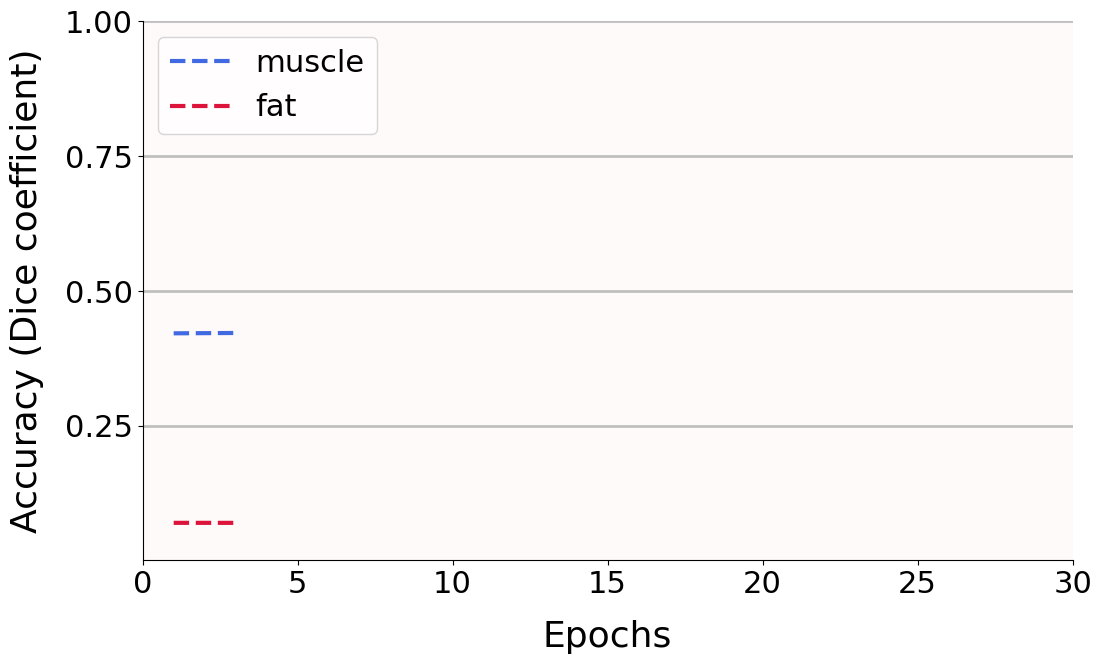

In [37]:
epochs_increments = 1
epochs_total = 30


## Plot training history
training_loss = Full_history['loss']
validation_dice_coef = Full_history['val_dice_coef']
validation_dice_coef_c1 = Full_history['val_dice_coef_c1']
validation_dice_coef_c2 = Full_history['val_dice_coef_c2']
validation_dice_coef_c3 = Full_history['val_dice_coef_c3']


epoch_count = range(1, len(training_loss) + 1)

plt.style.use('default')


fig1, axs = plt.subplots( figsize = (12, 7))

#dice coefficient validation
#axs.set_title("Model training evolution", fontsize = 20)
#axs.plot(epoch_count, validation_dice_coef, 'k')
#axs.plot(epoch_count, validation_dice_coef_c1, 'g--')
axs.plot(epoch_count, validation_dice_coef_c2, color = 'royalblue', linestyle ='--', linewidth = 3)
axs.plot(epoch_count, validation_dice_coef_c3, color = 'crimson', linestyle ='--', linewidth = 3)
plt.xlabel("Epochs", fontsize = 26, labelpad = 15)
plt.xticks(fontsize=22)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axs.grid(which='both', axis='y', linewidth =2, color = 'silver')
plt.xlim((0,epochs_total))
plt.ylabel("Accuracy (Dice coefficient)", fontsize = 26, labelpad = 15)
plt.yticks([0.25, 0.5, 0.75, 1], fontsize=22)
plt.gca().yaxis.grid(True)
plt.ylim((0,1))
axs.legend([  "muscle", "fat"], fontsize = 22, loc = "upper left")
axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.patch.set_facecolor('snow')
None

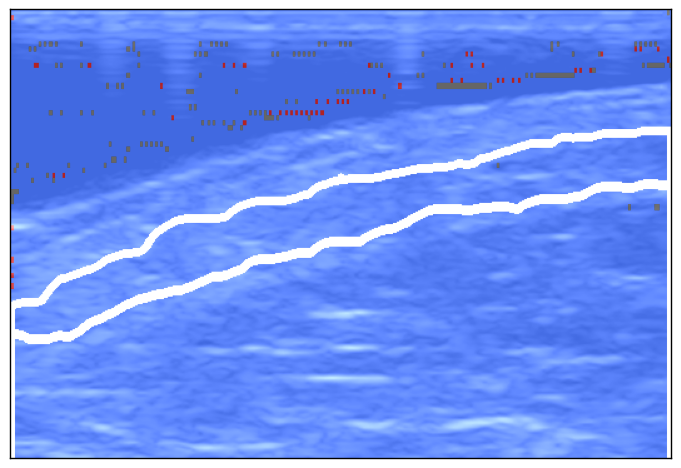

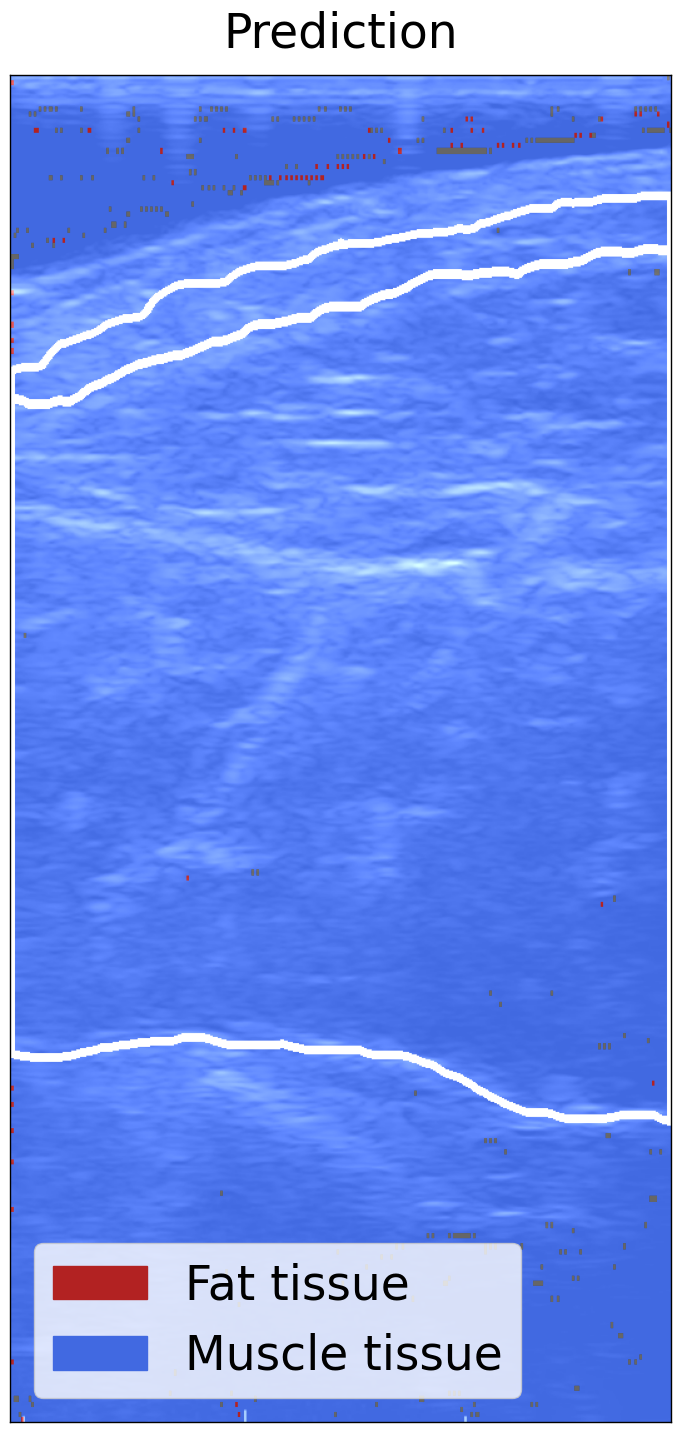

In [38]:
file_path = test_x[0]

# define color of labels:
mask_fat_color ='firebrick'
mask_muscle_color ='royalblue'                                                
contour_fat_color ='white'
contour_muscle_color ='white'

plot_image = file_path 
parent_directory = os.path.dirname(os.path.dirname(plot_image))
image_directory = PATH_IMAGES
mask_directory = PATH_MASKS
base_file = os.path.basename(plot_image)
file_name, fileext = os.path.splitext(base_file)
original_SIZE = read_original_size(plot_image) 

PLOTTING_WIDTH = round(original_SIZE[0])                                      # resizes the images for the plot
PLOTTING_HEIGHT = round(original_SIZE[1])


#path to image, mask, predicted mask
original_path = os.path.join(image_directory, base_file)
mask_image_path = os.path.join(mask_directory, base_file)
prediction_image_path = prediction_filepath
pr_base_file = os.path.basename(prediction_image_path)
pr_file_name, fileext = os.path.splitext(pr_base_file)

# read images as numpy arrays  
original = read_image_plotting(original_path, PLOTTING_WIDTH, PLOTTING_HEIGHT)
mask_area_image = create_overlay(mask_to_255(mask_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                            color1=mask_fat_color, color2=mask_muscle_color)

mask_outline_image = create_overlay(convert_mask_to_outline(mask_image_path, contour_width=6), 
                                    PLOTTING_WIDTH, PLOTTING_HEIGHT, color1=contour_fat_color, color2=contour_muscle_color)
prediction_image = create_overlay(Image.open(prediction_image_path), PLOTTING_WIDTH, PLOTTING_HEIGHT, 
                                  color1=mask_fat_color, color2=mask_muscle_color)



#create the overlay images  
merged_mask = cv2.addWeighted(mask_area_image, 1, original, 0.6, 0)                # choose level of transparency for first and second picture
merged_prediction = cv2.addWeighted(prediction_image, 1, original, 0.6, 0)
merged_prediction_mask = cv2.addWeighted(mask_outline_image, 1, prediction_image, 1, 0)
merged_image_both = cv2.addWeighted(merged_prediction_mask, 1, original, 0.6, 0)

######## create legend ########

colors = [mask_fat_color, mask_muscle_color]
texts = ["Fat tissue", "Muscle tissue"]
patches = [ mpatches.Patch(color=colors[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]

########  plot  #########

dpi = 80
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1



figsize = PLOTTING_WIDTH / float(dpi), PLOTTING_HEIGHT / float(dpi)

fig2 = plt.figure(figsize=(figsize[0], figsize[1]/3))
ax = fig2.add_axes([0, 0, 1, 1])
ax.imshow(crop_image(merged_image_both, (0, 0, PLOTTING_WIDTH, PLOTTING_HEIGHT/3)))
ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

fig2.savefig(PATH_OVERLAY_DETAIL + pr_base_file, transparent=False, bbox_inches='tight', pad_inches=0.05)

fig3 = plt.figure(figsize=figsize)
ax = fig3.add_axes([0, 0, 1, 1])
ax.set_title("Prediction", fontsize = 34, pad = 20)
ax.imshow(merged_image_both)
ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)

ax.legend(handles=patches, bbox_to_anchor=(0.0, 0.0), loc='lower left', ncol=1 , fontsize = 34)
fig3.savefig(PATH_OVERLAY + pr_base_file, transparent=False, bbox_inches='tight', pad_inches=0.05)


## Useful function for bugfixing


In [ ]:
###### Pixel count for images ######

def count_uniques(image_array=None):  
'''lists each pixel value and how often it appears in an image'''
  unique, counts = np.unique(image_array, return_counts=True)
  print(np.asarray((unique, counts)).T)
  print(img.shape)